<a href="https://colab.research.google.com/github/emichester/06MIAR_Aprendizaje_No_Supervisado/blob/main/NotebooksDeClase/VC06_M%C3%A9todos_de_clustering_probabil%C3%ADsticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VC06 - Métodos de clustering probabilísticos



En esta práctica vamos a ver cómo funciona el clustering probabilístico, en concreto, el basado en Mixtura de Modelos Gaussianos, que hace uso de modelos generativos para encontrar el mejor generador (compuesto por varias componentes) para los datos de los que disponemos y, de esa manera, ser capaces de separarlos.

## Gaussian Mixture Models

Vamos a recordar cómo funciona primero el k-means, en qué se parece al GMM y por qué podemos considerar el GMM como una generalización más potente del k-means.

Empezamos, como siempre, con los imports necesarios:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
import seaborn as sns; sns.set()
import numpy as np

### Las debilidades del k-Means

Está claro que el k-means es un algoritmo muy utilizado dentro del clustering, pero tiene sus debilidades.

Vamos a entenderlas mediante dos ejemplos.

Antes de nada, vamos a generar los datos para ambos ejemplos y a visualizarlos. Simplemente vamos a usar un dataset artificialmente generado con 2 centros, y luego vamos a "estirar" dicho dataset:

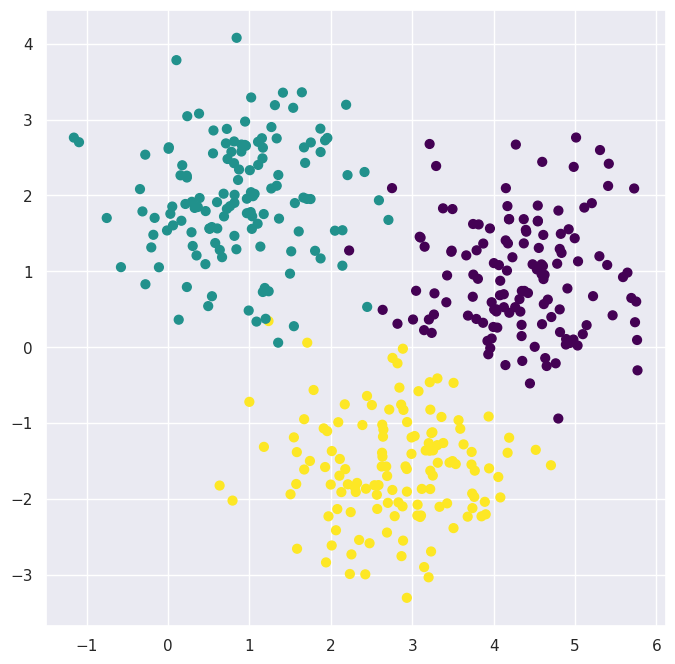

In [ ]:
# generamos nuestro dataset original
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=3,
                       cluster_std=0.75, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
# mostramos los datos originales
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis');

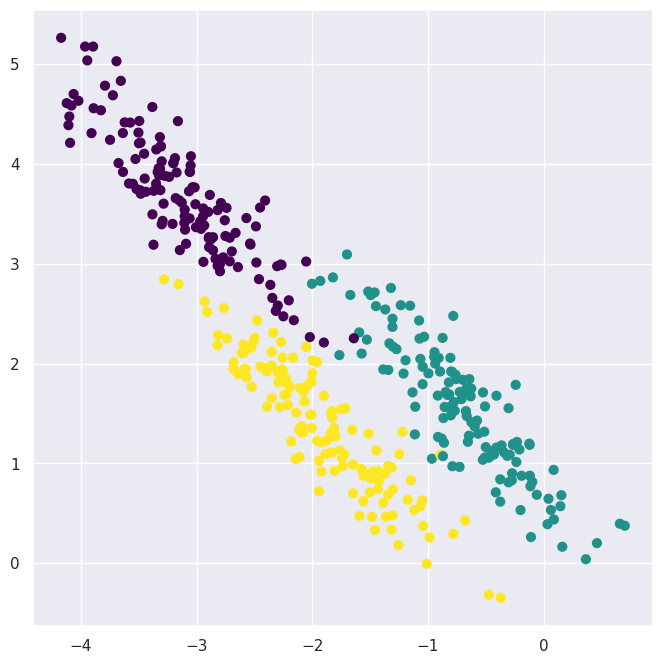

In [ ]:
# estiramos los datos
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
# mostramos los datos
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_true, s=40, cmap='viridis');

Ahora vamos a aplicar el mismo K-means exactamente sobre cada uno de ellos y observar los resultados.

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None, title=''):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

    ax.scatter(centers[:, 0], centers[:, 1], marker='*', c='w', s=300, zorder=3)
    ax.set_title(title)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


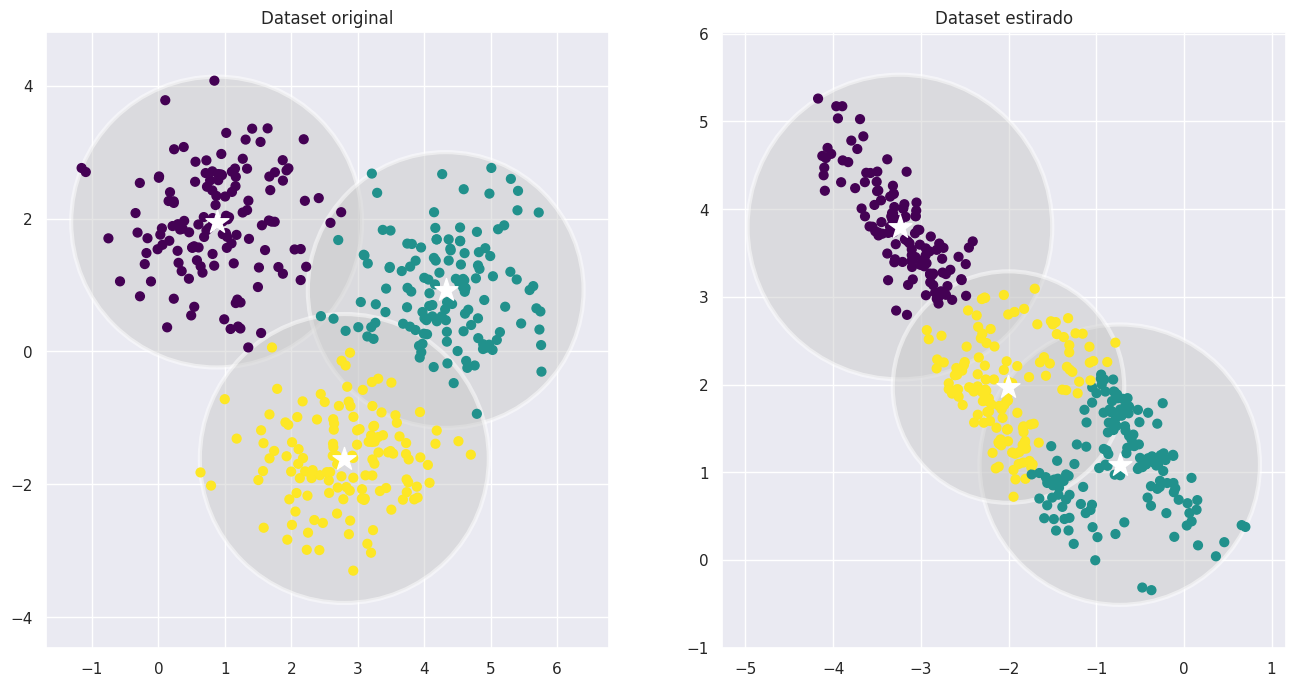

In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,2)

kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X, ax=ax[0], title='Dataset original')

kmeans = KMeans(n_clusters=3)
plot_kmeans(kmeans, X_stretched, ax=ax[1], title='Dataset estirado')
plt.rcParams['figure.figsize'] = [8, 8]

Si os fijáis, podemos observar varios problemas a simple vista:

- El k-means utilizar círculos (o en dimensions superiores, esferas o hiper-esferas) para delimitar los clusters, lo que muchas veces no se ajusta a la distribución real de nuestros datos. Esto es debido a la asunción de **independencia** entre las variables que usamos para clusterizar (covarianza es 0). Fijaos que realmente el tamaño del cluster no es el círculo blanco, sino el punto medio entre centroides.

- El k-means no permite decidir el tamaño de estos círculos (hiper-esferas), este tamaño viene dado por la posición de los centroides de cada cluster. Con lo cual, en caso de tener clusters de tamaño dispar, el kmeans no va a poder clasificarlos correctamente.

- El k-means realiza asignaciones deterministas (hard-classification) de las muestras a los clusters, incluso cuando no está claro si pertenecen a uno u otro. Parece útil que si un elemento está entre dos clusters, en vez de asignarlo a uno u a otro, le asignemos un 50% de probabilidad de pertenecer a cada uno, no os ¿parece?

Fijaos que todas estas limitaciones parecen bastante restrictivas, ¿verdad? ¿Y si encontraramos una generalización del k-means que solucionara estos problemas?

Pues si, los modelos de mezcla de gaussianas solucionan estos problemas!



## Generalizando el algoritmo de k-means (Expectation–Maximitation): Gaussian Mixture Models

Como ya sabemos, un modelo de mezcla de Gaussianas trata de encontrar una mezcla de distribuciones de probabilidad Gaussianas multidimensionales que sean capaces de **generar** los datos con los que tratamos.

En el caso más sencillo, los GMMs pueden encontrar los clusters de la misma forma que k-means:

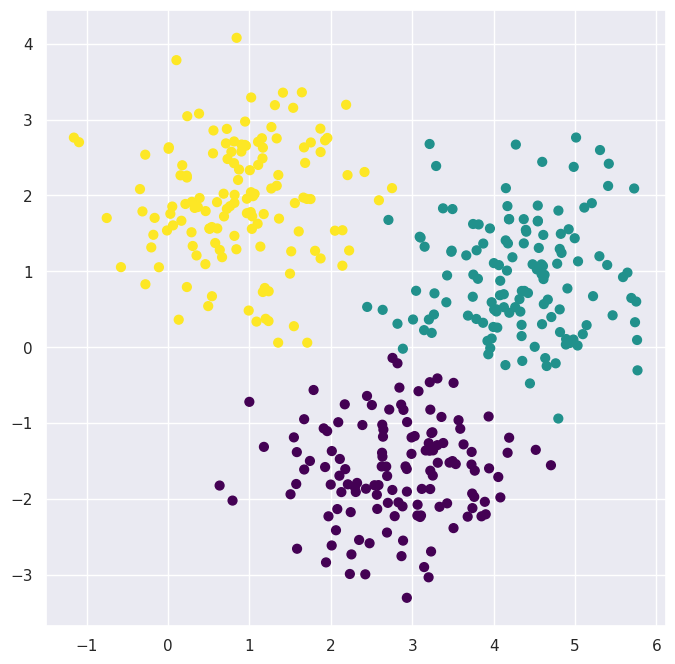

In [ ]:
from sklearn.mixture import GaussianMixture

gmm= GaussianMixture(n_components=3).fit(X)
labels= gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Pero fijaos que como GMM es un modelo probabilístico, no solo podemos encontrar a qué cluster pertenece cada muestra, sino también con qué probabilidad.

Esto lo podemos hacer usando la función ``predict_proba``, que devuelve una matriz de tamaño ``[n_samples, n_clusters]`` que mide la probabilidad de cada punto de pertenecer a cada cluster:

In [ ]:
probs = gmm.predict_proba(X)
print(probs[40:50].round(3))

[[0.101 0.006 0.893]
 [0.    0.    1.   ]
 [0.    0.    1.   ]
 [0.363 0.631 0.007]
 [0.022 0.978 0.   ]
 [0.    1.    0.   ]
 [0.    0.547 0.453]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]]


Fijaos que esta información es realmente útil. Si le asignamos un tamaño diferente a cada punto dependiendo de la certeza de su predicción, podemos visualizar gráficos como el siguiente, donde los puntos más pequeños son los que se encuentran entre dos clusters.

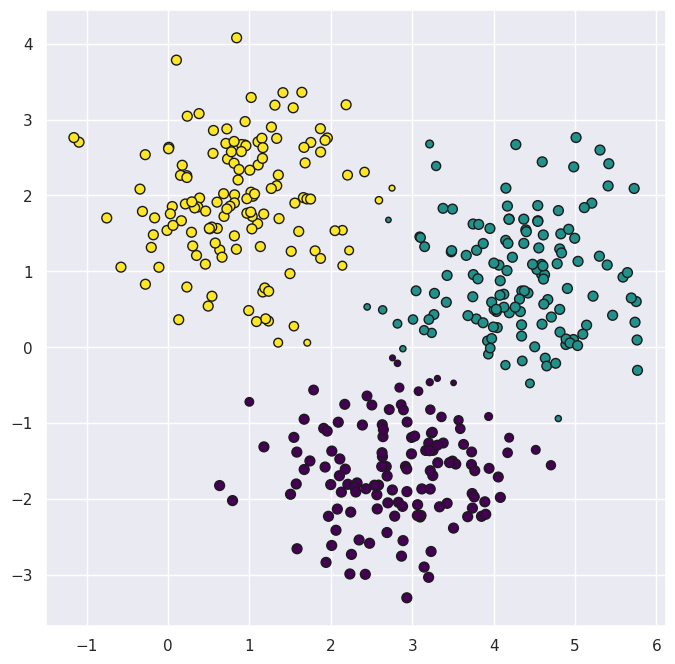

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, edgecolor='k');

Útil, no os parece?

Recordad que al final, un GMM es tremendamente similar to a un k-means, usa el algoritmo de esperanza-maximización:

1. Escoge unas estimaciones iniciales para la posición ($\mu_k$) y la forma ($\sum_k$) de cada cluster (**componente**)

2. Después, repite hasta converger los siguientes pasos:

   1. *Paso E*: para cada elemento de nuestro dataset, encuentra unos pesos ($\hat{z}_{ik}$) codifican la pertenencia de elemento punto a cada componente de nuestro GMM
   2. *Paso M*: para cada cluster (**componente**), actualiza su posición, forma y tamaño, utilizando los pesos anteriores y todas las muestras del dataset para calcular $\hat{\pi}_k$, $\hat{\mu}_k$ y $\hat{\Sigma}_k$

Y al final, cada elemento está asociado con las probabilidades de pertenecer a cada una de las componentes de nuestro GMM (**clusteres**).

Igual que en la versión del k-means, este algoritmo es sensible a la inicialización y puede no encontrar el máximo global, quedándose atrapado en un máximo local. Por ello, en la práctica utilizamos varias ejecuciones con distintas inicializaciones.

La siguiente función permite visualizar las elipses mostrando las curvas de nivel de las gaussianas en 2D:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='*', c='w', s=300, zorder=3)

Vamos a usarla para visualizar el clustering anterior:

<ipython-input-9-980ceb83b253>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


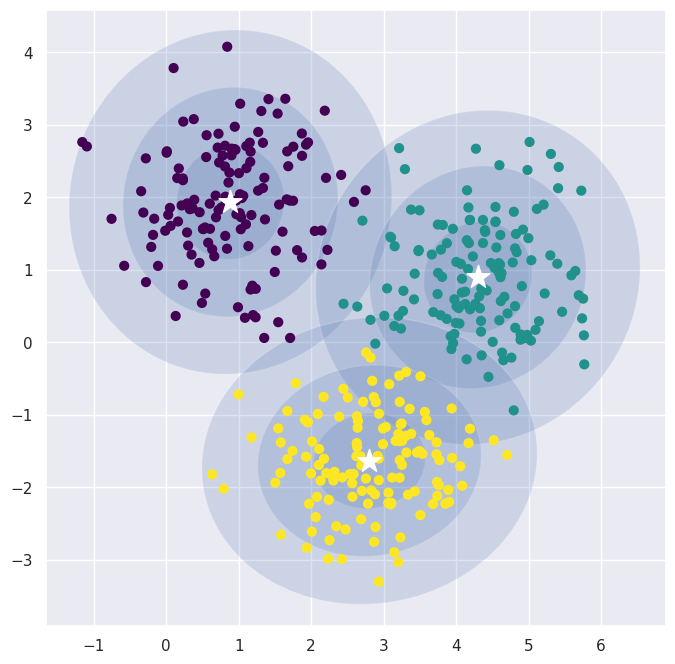

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

Hasta ahora solo hemos visto cómo se comporta con el dataset original, vamos a ver qué tal con el "estirado":

<ipython-input-9-980ceb83b253>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


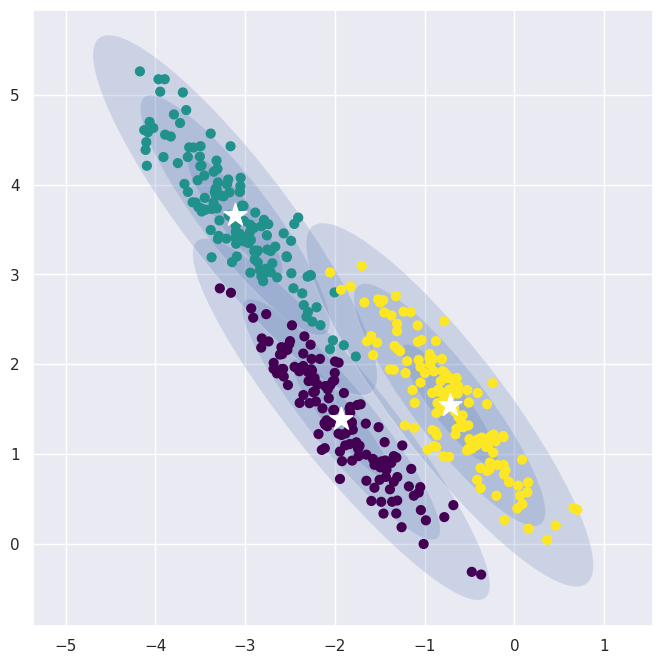

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Fijaos que como hemos comentado, el GMM es capaz de dar solución a las limitaciones del k-means comentadas anteriormente.

Fijaos también que le hemos indicado un parámetro `covariance_type`. Este parámetro simplemente indica cómo va a ser la matriz de covarianzas. Puede tomar los siguientes valores:

- `spherical`: únicamente la diagonal principal de la matriz de covarianzas va a ser distinta de cero, y además todos los valores van a ser iguales
- `diag`: únicamente la diagonal principal de la matriz de covarianzas va a ser distinta de cero.
- `full`: sin restricciones en la matriz de covarianzas.

Con lo que sabéis, ¿qué creéis que va a implicar cada una de estas opciones?


## GMM como estimador de densidad

Aunque hayamos categorizado al GMM como un algoritmo de clustering, estamos hablando, fundamentalmente, de un algoritmo de estimación de densidad.

Es decir, estamos hablando de un modelo probabilístico generativo capaz de describir la distribución de los datos (y cuanto mejor la describa, mejor seremos capaces de agruparlos).

Por ejemplo, si cogemos como dataset el siguiente:

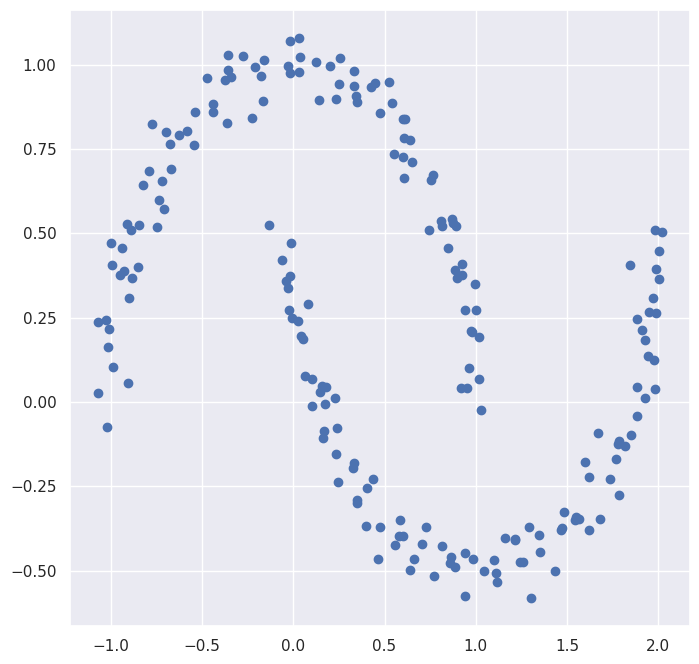

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Podemos intentar encontrar un GMM capaz de **generar** los datos. Vamos a probar con 2 componentes:

<ipython-input-9-980ceb83b253>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


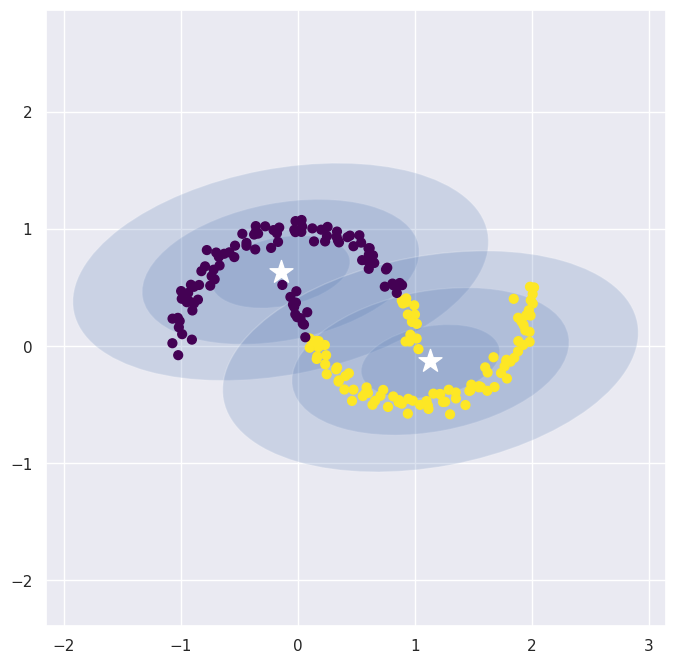

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Claramente, no es suficiente. Vamos a ver con 10:

<ipython-input-9-980ceb83b253>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


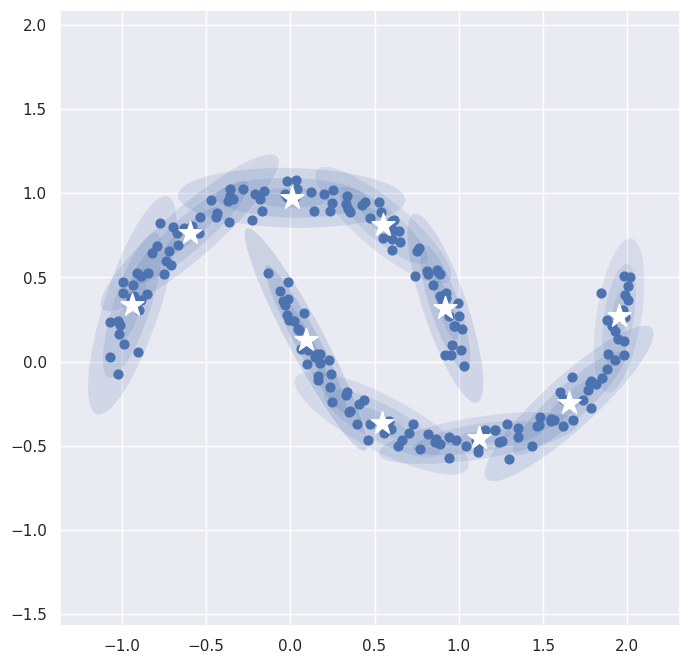

In [ ]:
gmm10 = GaussianMixture(n_components=10, covariance_type='full', random_state=0)
plot_gmm(gmm10, Xmoon, label=False)

Si os fijáis, este GMM es capaz de **generar** perfectamente los datos que tenemos. Lo que está ocurriendo en este caso no es que estemos clusterizando los datos, sino que estamos modelando la *distribución* de los datos, y si quisieramos, podríamos generar más:

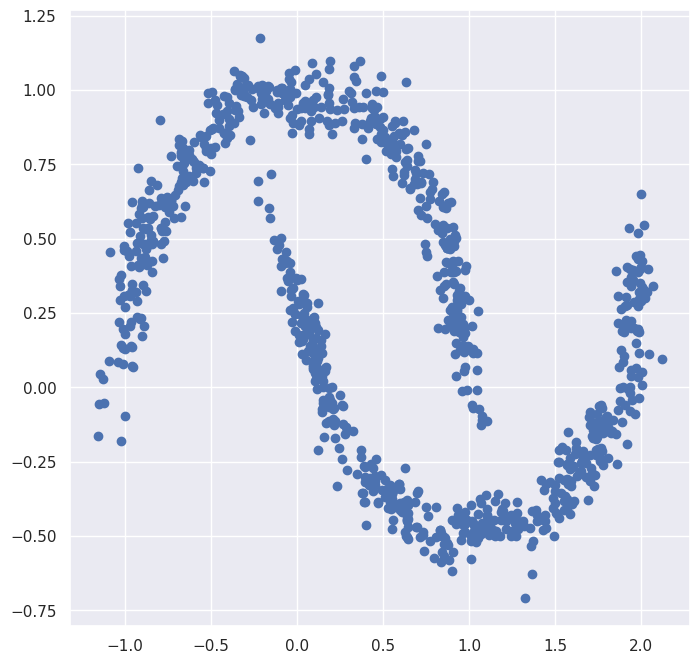

In [ ]:
Xnew, y = gmm10.sample(1000)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

Como podéis ver, GMM es capaz de modelar practicamente cualquier distribución de datos multi-dimensional.

### Cómo escogemos cuantas componentes?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

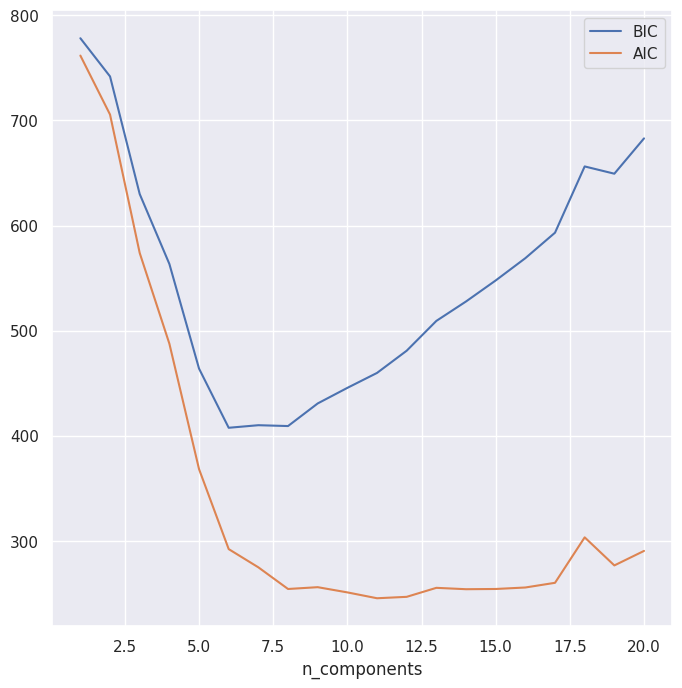

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Ejemplo: Vamos a generar nuevos datos

Vamos a tratar de generar nuevos dígitos similares a los disponibles en el dataset `digits`:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Veamos algunas imágenes:

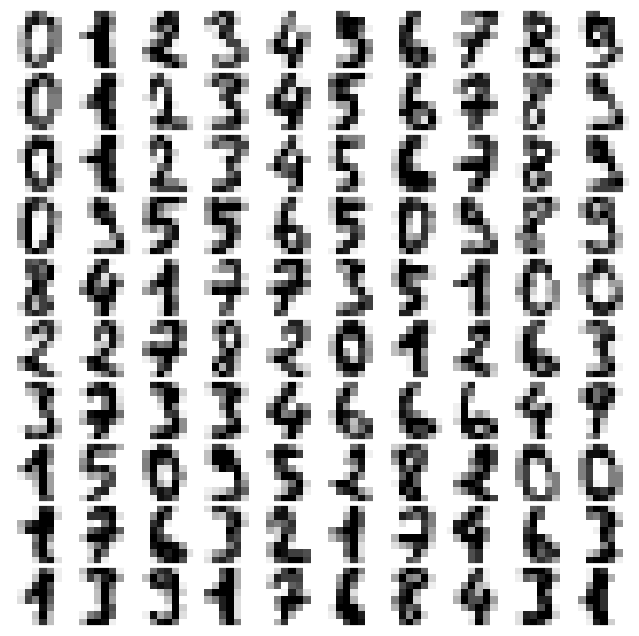

In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Tenemos 1800 dígitos de 8x8 píxels, es decir, 64 dimensiones. Vamos a ver cuantas componentes necesitamos para *modelar* nuestros datos 64-dimensionales:

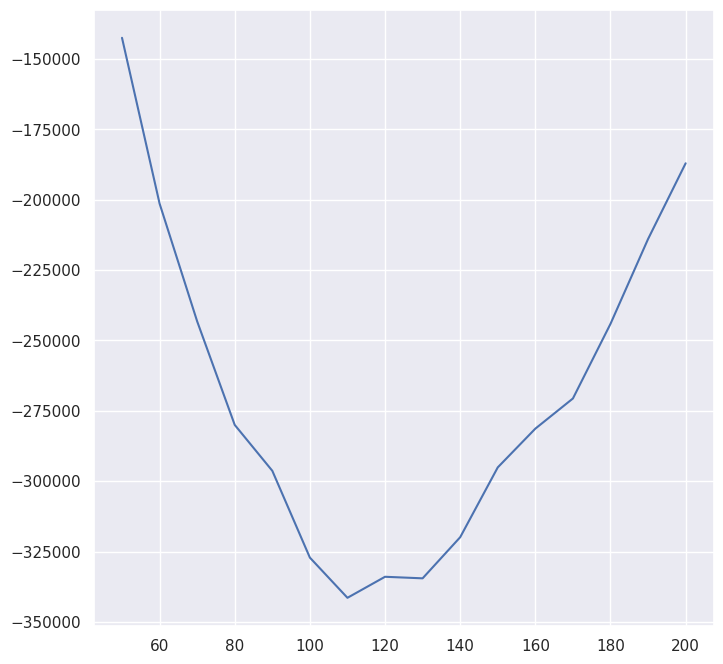

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(digits.data).aic(digits.data) for model in models]
plt.plot(n_components, aics);

De acuerdo al AIC, parece que `n_componentes=110` es una buena estimación. Vamos a crear nuestro modelo GMM y ver si ha convergido:

In [ ]:
gmm= GaussianMixture(n_components=3).fit(digits.data)
nuevos_datos, etiqueta = gmm.sample(1)
nuevos_datos.shape

(1, 64)

In [ ]:
gmm = GaussianMixture(n_components=110, covariance_type='full', random_state=0)
gmm.fit(digits.data)
print(gmm.converged_)

True


Perfecto. Ahora podemos simplemente muestrear nuevos elementos de nuestra mixtura de gaussianas, y deberíamos obtener imágenes parecidas. Veamos si es verdad:

In [ ]:
data_new, y_new = gmm.sample(100)
data_new.shape

(100, 64)

Vamos a visualizar nuestros nuevos datos:

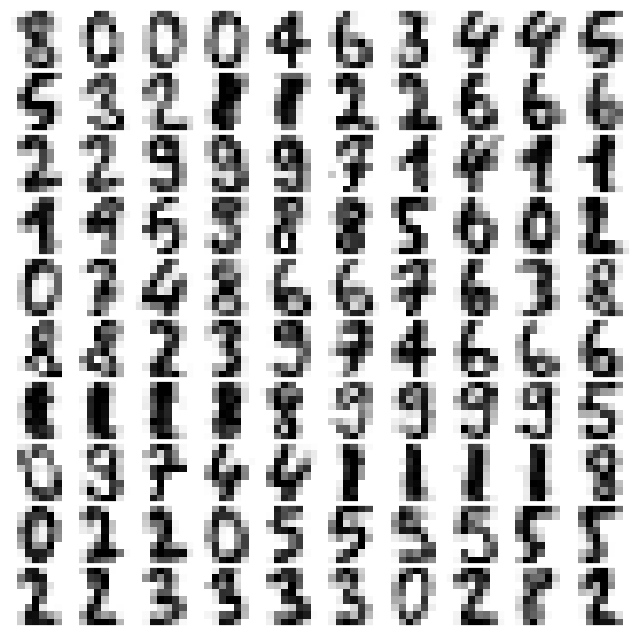

In [ ]:
plot_digits(data_new)

¡Fijaos que somos capaces efectivamente de generar nuevos datos como los que teníamos!

FUENTE: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html